In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(font="Arial", style="ticks", palette="gray")

In [2]:
projects_df = pd.read_csv("./raw_data/Projects.csv")
projects_df.columns

Index(['agencyCode', 'agencyName', 'currentUII', 'investmentName',
       'investmentType', 'uniqueProjectId', 'projectId', 'agencyProjectId',
       'projectName', 'projectGoal', 'infrastructureManagementCategory',
       'projectStatus', 'tmfInitiative', 'softwareProject',
       'incrementalDevelopment', 'iterationFrequencyAmount',
       'iterationFrequencyUnits', 'iterativeDescription', 'plannedStartDate',
       'projectedStartDate', 'actualStartDate', 'plannedEndDate',
       'projectedEndDate', 'actualEndDate', 'plannedCost', 'projectedCost',
       'actualCost', 'scheduleVariance(days)', 'scheduleVariance(%)',
       'scheduleVarianceColor', 'costVariance($M)', 'costVariance(%)',
       'costVarianceColor', 'updatedTime'],
      dtype='object')

## overperfect data

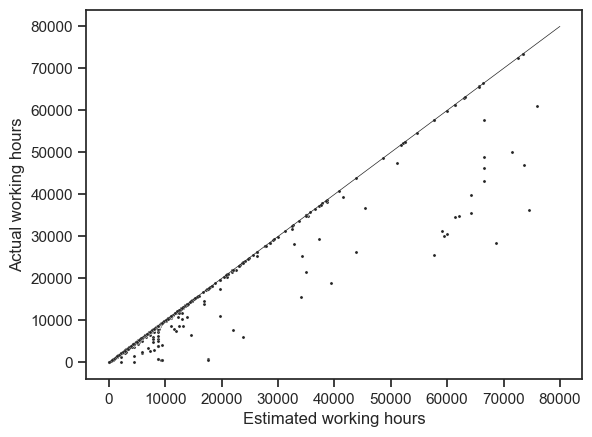

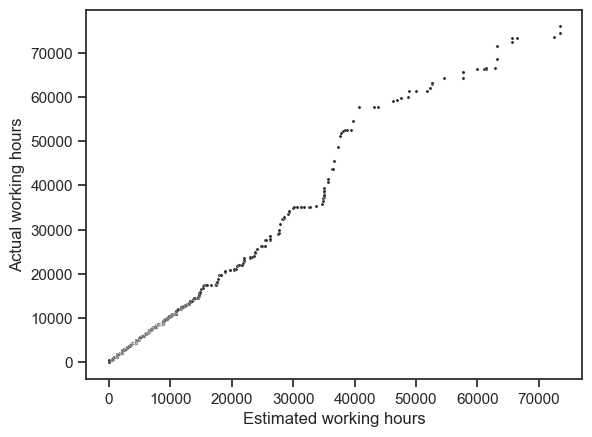

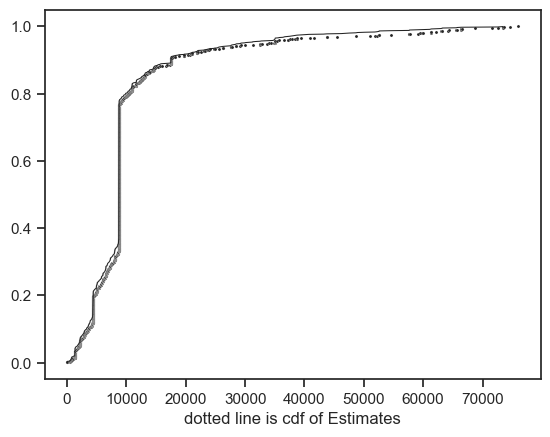

In [3]:
df = pd.DataFrame()

df["actual"] = (pd.to_datetime(projects_df["actualEndDate"]) - pd.to_datetime(projects_df["actualStartDate"])).dt.days * 24
df["estimate"] = (pd.to_datetime(projects_df["plannedEndDate"]) - pd.to_datetime(projects_df["plannedStartDate"])).dt.days * 24
df = df.dropna()
df["difference"] = df["estimate"] - df["actual"]
df = df[(df["difference"] >= 0) & (df["actual"] <= 80000) & (df["estimate"] <= 80000)]

# visualization
plt.clf()
ax = sns.scatterplot(x="estimate", y="actual", data=df, s=5)
ax = sns.lineplot(x=[0, 80000], y=[0, 80000], linewidth=0.5)
ax.set_xlabel("Estimated working hours")
ax.set_ylabel("Actual working hours")
plt.show()

# Q-Q
plt.clf()
ax = sns.scatterplot(x=np.sort(df["actual"]), y=np.sort(df["estimate"]), s=5)
ax.set_xlabel("Estimated working hours")
ax.set_ylabel("Actual working hours")
plt.show()

# cdf
plt.clf()
sorted_actual = np.sort(df["actual"])
sorted_estimate = np.sort(df["estimate"])
ax = sns.lineplot(x=sorted_actual, y=np.arange(1, len(sorted_actual) + 1) / len(sorted_actual), linewidth=0.75)
ax = sns.scatterplot(x=sorted_estimate, y=np.arange(1, len(sorted_estimate) + 1) / len(sorted_estimate), s=5)
ax.set_xlabel("dotted line is cdf of Estimates")
plt.show()

## overregulation

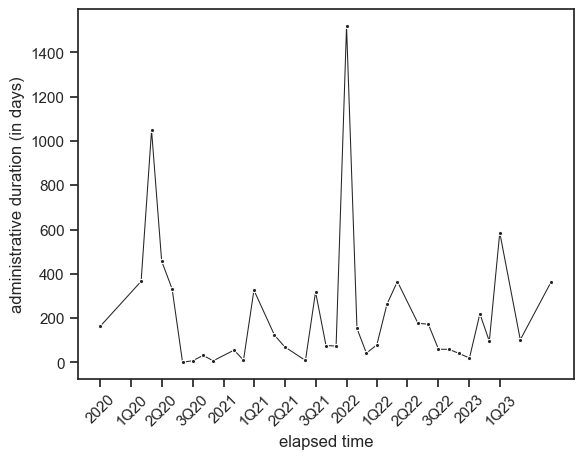

,mean,min,25%,50%,75%,max
difference,222.589184,1.0,48.5,102.0,322.166667,1519.0


In [4]:
df = pd.DataFrame()

df["actual"] = pd.to_datetime(projects_df["actualStartDate"])
df["planned"] = pd.to_datetime(projects_df["plannedStartDate"])
df = df.dropna()

df["difference"] = (df["actual"] - df["planned"]).dt.days
df["date"] = pd.to_datetime(df["actual"].dt.to_period("M").astype(str) + "-01")
df = df[(df["actual"].dt.year >= 2020) & (df["difference"] > 0)]

df = df.groupby("date")["difference"].mean().reset_index()

plt.clf()
ax = sns.lineplot(x="date", y="difference", data=df, linewidth=0.75, marker=".")
ax.set_xticks(["2020-01-01", "2020-04-01", "2020-07-01", "2020-10-01", "2021-01-01", "2021-04-01", "2021-07-01", "2021-10-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01", "2023-01-01", "2023-04-01"])
ax.set_xticklabels(["2020", "1Q20", "2Q20", "3Q20", "2021", "1Q21", "2Q21", "3Q21", "2022", "1Q22", "2Q22", "3Q22", "2023", "1Q23"], rotation=45)
ax.set_xlabel("elapsed time")
ax.set_ylabel("administrative duration (in days)")
plt.show()

stats_df = df.describe()[["difference"]].drop(["count", "std"]); stats_df.T

## underregulation

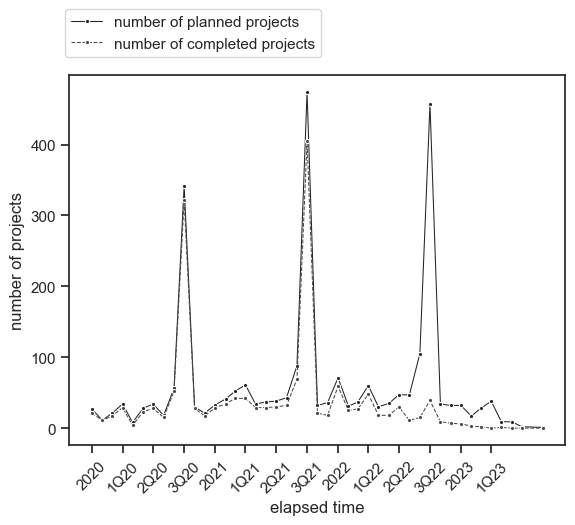

,mean,min,25%,50%,75%,max
status,,,,,,
projects,61.840909,1.0,27.75,34.0,47.0,474.0
reports,37.840909,0.0,10.50,22.0,30.5,405.0


In [5]:
df = pd.DataFrame()
df["actual"] = pd.to_datetime(projects_df["actualStartDate"])
df["status"] = projects_df["projectStatus"]
df = df.dropna()

df["date"] = pd.to_datetime(df["actual"].dt.to_period("M").astype(str) + "-01")
stats = df.groupby(["date", "status"]).size().unstack(fill_value=0)
stats["projects"] = stats["Canceled"] + stats["Complete"] + stats["Completed"] + stats["In Progress"]
stats["reports"] = stats["Complete"] + stats["Completed"]
stats["date"] = pd.to_datetime(stats.index)

stats = stats[(stats["date"].dt.year >= 2020)]

plt.clf()
ax = sns.lineplot(x="date", y="projects", data=stats, linewidth=0.75, marker=".", label="number of planned projects")
ax = sns.lineplot(x="date", y="reports", data=stats, linewidth=0.75, marker=".", linestyle="--", label="number of completed projects")
ax.set_xticks(["2020-01-01", "2020-04-01", "2020-07-01", "2020-10-01", "2021-01-01", "2021-04-01", "2021-07-01", "2021-10-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01", "2023-01-01", "2023-04-01"])
ax.set_xticklabels(["2020", "1Q20", "2Q20", "3Q20", "2021", "1Q21", "2Q21", "3Q21", "2022", "1Q22", "2Q22", "3Q22", "2023", "1Q23"], rotation=45)
ax.set_xlabel("elapsed time")
ax.set_ylabel("number of projects")
plt.legend(bbox_to_anchor=(0.25, 1.2), loc="upper center")
plt.show()

stats_df = stats.describe()[["projects", "reports"]].drop(["count", "std"]); stats_df.T